In [6]:
cd ~/Downloads/dataset/

/home/owenoertell/Downloads/dataset


In [3]:
# Import needed libraries.

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [71]:
# Setting hyperparameters. In this case the image height and width are used to make the data more uniform.
# eventually do need resize image to then pass to the model in practice. 

batch_size = 32
img_height = 256
img_width = 256

# Import that training dataset. This dataset consisted of a total of 3833 images. Used the standard 20% for
# validation and 80% for training.

trainDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/owenoertell/Downloads/dataset/", labels='inferred', label_mode='categorical',
    color_mode='grayscale', batch_size=32, image_size=(img_width, img_height), shuffle=True, seed=4236,
    validation_split=0.2, subset="training", interpolation='bilinear')

validationDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/owenoertell/Downloads/dataset/", labels='inferred', label_mode='categorical',
    color_mode='grayscale', batch_size=32, image_size=(img_width, img_height), shuffle=True, seed=4236,
    validation_split=0.2, subset="validation", interpolation='bilinear')

Found 3833 files belonging to 2 classes.
Using 3067 files for training.
Found 3833 files belonging to 2 classes.
Using 766 files for validation.


In [10]:
# Define the model.

model = Sequential([
  # The first layer is a rescaling to normalize the data. By ensuring that all of the values are approxomately
  # similar this makes the weights more effective.
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  # Convolution layers. First argument is the number of kernals for the covolution to learn,
  # second is the size of the convolution window, padding is for if the convolution window runs over.
  # Activation function is used to remove a linear association. The rectify linear (very common function) was used.
  # the relu(x) = max(0,x)
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # Reduces the sampling size and 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Flatten fixes the shape to be passed to dense node layer. 
  layers.Flatten(),
  # Apply dropout. This means that the rate 0.6 the input will become 0. This is used to prevent overfitting
  # of the model to the data.
  layers.Dropout(0.6),
  # Passed to dense layer with 128 nodes. Uses relu activation function again
  layers.Dense(128, activation='relu'),
  # Passed to the prediction layer. Each node represents a class. In this case one represents mask and the other
  # not having a mask.
  layers.Dense(2)
])

In [17]:
model.compile(
  # Uses the adam optimizer. While could have manually tuned hyperparameters, the adam optamiser is usually
  # sufficent and in this case it was.
  optimizer='adam',
  # Specify the way loss is measured. Categorical crossentropy quantifies the error of a prediction during
  # training.
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  # Metrics to measure for each epoch. Used to look for instances of overfitting and/or if the model is
  # approaching optimal accuracy.
  metrics=['accuracy', 'mean_squared_error'])

In [18]:
# Train the model. Pass in training and validation data sets along with the number of epochs.
# 10 epochs was chosen to allow the model to be quite accurate but not overfit.
modelOutput = model.fit(
  trainDataSet,
  validation_data=validationDataSet,
  epochs=10
)

Epoch 1/10
96/96 [==============================] - 84s 873ms/step - loss: 0.4853 - accuracy: 0.7590 - mean_squared_error: 0.8730 - val_loss: 0.3903 - val_accuracy: 0.8003 - val_mean_squared_error: 1.3686
Epoch 2/10
96/96 [==============================] - 83s 865ms/step - loss: 0.3236 - accuracy: 0.8556 - mean_squared_error: 2.0643 - val_loss: 0.3584 - val_accuracy: 0.8316 - val_mean_squared_error: 3.2056
Epoch 3/10
96/96 [==============================] - 62s 644ms/step - loss: 0.2256 - accuracy: 0.9077 - mean_squared_error: 4.4964 - val_loss: 0.2859 - val_accuracy: 0.8930 - val_mean_squared_error: 8.9658
Epoch 4/10
96/96 [==============================] - 57s 591ms/step - loss: 0.1684 - accuracy: 0.9273 - mean_squared_error: 7.4124 - val_loss: 0.2817 - val_accuracy: 0.8982 - val_mean_squared_error: 12.7934
Epoch 5/10
96/96 [==============================] - 56s 583ms/step - loss: 0.1292 - accuracy: 0.9547 - mean_squared_error: 11.7158 - val_loss: 0.2425 - val_accuracy: 0.9282 - val_

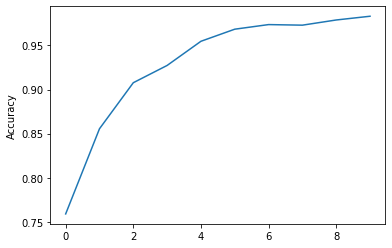

In [74]:
# Plot model accuracy during training. The final and maximum validation accuracy was 0.9373

hist = pd.DataFrame(modelOutput.history)
plt.plot(hist['accuracy'])
plt.ylabel('Accuracy')
plt.show()

In [26]:
# While this code was not used in the final iteration, it captures and reads input.

import numpy as np
import cv2 as cv

# Capture camera input
cap = cv.VideoCapture(0)
ret, frame = cap.read()
grayScaleValue = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
cap.release()

# Create haar and read face.

# Load model for face detection
faceCascade = cv.CascadeClassifier('/home/owenoertell/Downloads/haarcascade_frontalface_default.xml')

# dectect faces. One signficant blocker we ran into was that facial detection with a mask was quite difficult.
# which led us to needing to reduce the threshold for facial detection.
faces = faceCascade.detectMultiScale(
        grayScaleValue,
        scaleFactor=1.02,
        minNeighbors=5,
        minSize=(10, 10)
    )
# Splice the orignal picture to include only the face.
for (x,y,w,h) in faces:
    #cv.rectangle(grayScaleValue,(x,y),(x+w,y+h),(255,0,0),2)
    face = grayScaleValue[y:y+h, x:x+w]

In [27]:
# Parse the face array. Add dimensions to allow for preprocessing by keras.
newFace = np.expand_dims(face, axis=0)

faceAsImg = tf.keras.preprocessing.image.array_to_img(newFace, data_format='channels_first')
# resize image to fit 256x256 as set by hyperparameters.
newFaceAsImage = faceAsImg.resize([256,256],1)

# Convert back to array and display image.
imgAsArray = tf.keras.preprocessing.image.img_to_array(newFaceAsImage, data_format='channels_first')
newFaceAsImage.show()

In [28]:
# Use the model to make a prediction on the taken image.
predictions = model.predict(imgAsArray)

# Use softmax function to get a score.
score = tf.nn.softmax(predictions[0])
class_names = ["yes mask", "no mask"]
# Using the argmax value, report which class to which the image most likely belongs.
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

NameError: name 'model' is not defined